# INSY 695 - Base Models + Exogenous Variables

In [1]:
import pandas as pd
import numpy as np
import os
import platform as pf
from IPython.display import display # Display data
pd.options.mode.chained_assignment = None  # default='warn'

#comment
#packages for time series
import warnings
import itertools    
import statsmodels.api as sm

#Richard was here
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import math
from scipy import stats

plt.style.use('fivethirtyeight')

## 1. Load Data 

In [25]:
import sys
import os

%run Categorical_Value_Processing.ipynb

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
0,2012-10-01 13:00:00,heavy clouds,93.0,230.0,285.830000,1001.0,4.0,1,0,0,0,0,0,0,0,3.0
1,2012-10-01 14:00:00,sky is clear,91.0,230.0,285.834650,986.0,4.0,0,0,0,0,0,0,0,0,0.0
2,2012-10-01 15:00:00,sky is clear,87.0,231.0,285.847790,945.0,4.0,0,0,0,0,0,0,0,0,0.0
3,2012-10-01 16:00:00,sky is clear,84.0,233.0,285.860929,904.0,4.0,0,0,0,0,0,0,0,0,0.0
4,2012-10-01 17:00:00,sky is clear,80.0,234.0,285.874069,863.0,3.0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45247,2017-11-29 20:00:00,moderate clouds,64.0,300.0,275.130000,1021.0,10.0,1,0,0,0,0,0,0,0,2.0
45248,2017-11-29 21:00:00,moderate clouds,59.0,300.0,274.130000,1023.0,7.0,1,0,0,0,0,0,0,0,2.0
45249,2017-11-29 22:00:00,light clouds,66.0,290.0,273.480000,1024.0,7.0,1,0,0,0,0,0,0,0,1.0
45250,2017-11-29 23:00:00,light clouds,58.0,290.0,272.480000,1026.0,4.0,1,0,0,0,0,0,0,0,1.0


In [45]:
#need to specify datetime[ns] or else the rest will not run 
df['datetime'] = df['datetime'].astype('datetime64[ns]')
weather_df = df.set_index('datetime')
weather_df

,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
datetime,,,,,,,,,,,,,,,
2012-10-01 13:00:00,heavy clouds,93.0,230.0,285.830000,1001.0,4.0,1,0,0,0,0,0,0,0,3.0
2012-10-01 14:00:00,sky is clear,91.0,230.0,285.834650,986.0,4.0,0,0,0,0,0,0,0,0,0.0
2012-10-01 15:00:00,sky is clear,87.0,231.0,285.847790,945.0,4.0,0,0,0,0,0,0,0,0,0.0
2012-10-01 16:00:00,sky is clear,84.0,233.0,285.860929,904.0,4.0,0,0,0,0,0,0,0,0,0.0
2012-10-01 17:00:00,sky is clear,80.0,234.0,285.874069,863.0,3.0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-29 20:00:00,moderate clouds,64.0,300.0,275.130000,1021.0,10.0,1,0,0,0,0,0,0,0,2.0
2017-11-29 21:00:00,moderate clouds,59.0,300.0,274.130000,1023.0,7.0,1,0,0,0,0,0,0,0,2.0
2017-11-29 22:00:00,light clouds,66.0,290.0,273.480000,1024.0,7.0,1,0,0,0,0,0,0,0,1.0


<AxesSubplot:xlabel='datetime'>

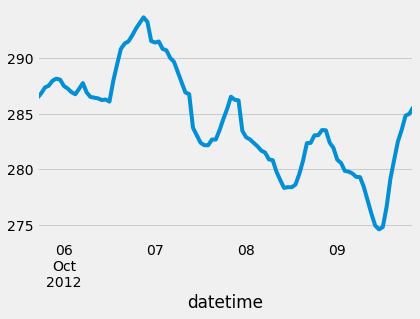

In [75]:
weather_df['Temperature'][100:200].plot()

<AxesSubplot:xlabel='datetime'>

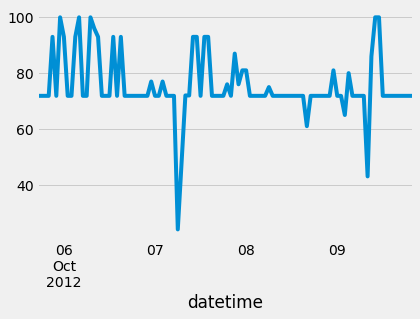

In [74]:
weather_df['Humidity'][100:200].plot()

<AxesSubplot:xlabel='datetime'>

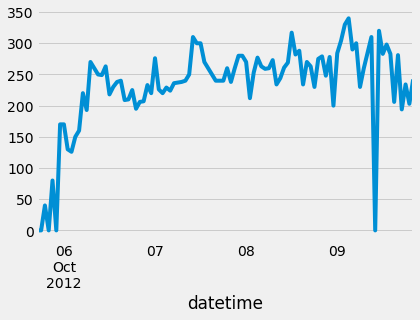

In [73]:
weather_df['Wind Direction'][100:200].plot()

<AxesSubplot:xlabel='datetime'>

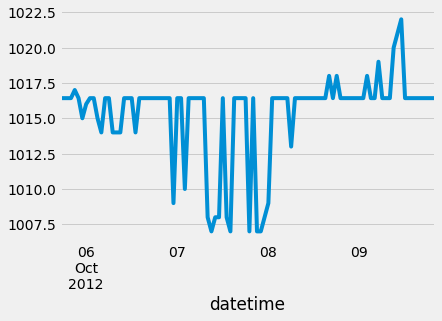

In [72]:
weather_df['Pressure'][100:200].plot()

In [87]:
#CREATE LAGGED ATTRIBUTES 
ml_df = weather_df.copy()
ml_df['date'] = ml_df.index
ml_df['month'] = ml_df['date'].dt.day
ml_df['month'] = ml_df['date'].dt.month
ml_df['year'] = ml_df['date'].dt.year

ml_df['Temp_lag1'] = ml_df['Temperature'].shift(periods = 1, fill_value = 0)
ml_df['Temp_lag2'] = ml_df['Temperature'].shift(periods = 2, fill_value = 0)
ml_df['Temp_lag12'] = ml_df['Temperature'].shift(periods = 12, fill_value = 0)
ml_df['Temp_lag24'] = ml_df['Temperature'].shift(periods = 24, fill_value = 0)

ml_df['Humidity_lag1'] = ml_df['Humidity'].shift(periods = 1, fill_value = 0)
ml_df['Humidity_lag2'] = ml_df['Humidity'].shift(periods = 2, fill_value = 0)
ml_df['Humidity_lag12'] = ml_df['Humidity'].shift(periods = 12, fill_value = 0)
ml_df['Humidity_lag24'] = ml_df['Humidity'].shift(periods = 24, fill_value = 0)

ml_df['Wind_Direction_lag1'] = ml_df['Wind Direction'].shift(periods = 1, fill_value = 0)
ml_df['Pressure_lag1'] = ml_df['Pressure'].shift(periods = 1, fill_value = 0)
ml_df['Wind_Speed_lag1'] = ml_df['Wind Speed'].shift(periods = 1, fill_value = 0)
ml_df['clouds_lag1'] = ml_df['clouds'].shift(periods = 1, fill_value = 0)
ml_df['rain_lag1'] = ml_df['rain'].shift(periods = 1, fill_value = 0)
ml_df['mist_lag1'] = ml_df['mist'].shift(periods = 1, fill_value = 0)
ml_df['snow_lag1'] = ml_df['snow'].shift(periods = 1, fill_value = 0)
ml_df['shower_lag1'] = ml_df['shower'].shift(periods = 1, fill_value = 0)
ml_df['thunderstorm_lag1'] = ml_df['thunderstorm'].shift(periods = 1, fill_value = 0)
ml_df['fog_lag1'] = ml_df['fog'].shift(periods = 1, fill_value = 0)
ml_df['other_lag1'] = ml_df['other'].shift(periods = 1, fill_value = 0)
ml_df['intensity_lag1'] = ml_df['Intensity'].shift(periods = 1, fill_value = 0)

In [88]:
ml_df['avg_temp'] = 0 
for i in range(1, len(ml_df)):
    ml_df['avg_temp'][i] = ml_df['Temp_lag1'][:i+1].mean()
    
#we have to eliminate all those with 0s
ml_df = ml_df[ml_df['Temp_lag24'] != 0]

In [89]:
ml_df.drop(['Description','Humidity','Pressure','Wind Direction','Wind Speed','clouds','rain','mist','snow','shower','thunderstorm','fog','other','Intensity','date'], axis = 1, inplace = True)

In [90]:
ml_df

,Temperature,month,year,Temp_lag1,Temp_lag2,Temp_lag12,Temp_lag24,Humidity_lag1,Humidity_lag2,Humidity_lag12,Humidity_lag24,Wind_Direction_lag1,Pressure_lag1,Wind_Speed_lag1,clouds_lag1,rain_lag1,mist_lag1,snow_lag1,shower_lag1,thunderstorm_lag1,fog_lag1,other_lag1,intensity_lag1,avg_temp
datetime,,,,,,,,,,,,,,,,,,,,,,,,
2012-10-02 13:00:00,286.13686,10,2012,286.123721,286.110581,285.979185,285.830000,7.000000,11.000000,49.0,93.0,261.0,1016.424953,0.0,0,0,0,0,0,0,0,0,0.0,274
2012-10-02 14:00:00,286.15000,10,2012,286.136860,286.123721,285.992325,285.834650,71.861538,7.000000,45.0,91.0,262.0,1016.424953,0.0,0,0,0,0,0,0,0,0,0.0,274
2012-10-02 15:00:00,287.55000,10,2012,286.150000,286.136860,286.005465,285.847790,71.861538,71.861538,42.0,87.0,264.0,1016.424953,0.0,0,0,0,0,0,0,0,0,0.0,275
2012-10-02 16:00:00,288.14000,10,2012,287.550000,286.150000,286.018604,285.860929,82.000000,71.861538,38.0,84.0,280.0,1002.000000,5.0,1,0,0,0,0,0,0,0,3.0,275
2012-10-02 17:00:00,288.69000,10,2012,288.140000,287.550000,286.031744,285.874069,71.861538,82.000000,34.0,80.0,276.0,1016.424953,1.0,0,0,0,0,0,0,0,0,0.0,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-29 20:00:00,275.13000,11,2017,276.450000,276.150000,275.380000,273.750000,73.000000,73.000000,80.0,59.0,280.0,1019.000000,8.0,1,0,0,0,0,0,0,0,2.0,280
2017-11-29 21:00:00,274.13000,11,2017,275.130000,276.450000,277.450000,274.050000,64.000000,73.000000,93.0,59.0,300.0,1021.000000,10.0,1,0,0,0,0,0,0,0,2.0,280
2017-11-29 22:00:00,273.48000,11,2017,274.130000,275.130000,278.770000,274.050000,59.000000,64.000000,87.0,59.0,300.0,1023.000000,7.0,1,0,0,0,0,0,0,0,2.0,280


## Model 1. XGB With Exogenous Variables

In [56]:
y = ml_df[['Temperature']]
X = ml_df.drop('Temperature', axis =1)

In [59]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(ml_df)*0.80)

X_train, X_test = train_test_split(X, split_len)
y_train, y_test = train_test_split(y, split_len)

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_train.columns = X.columns

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
X_test.columns = X.columns

In [156]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [157]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6202727235997456

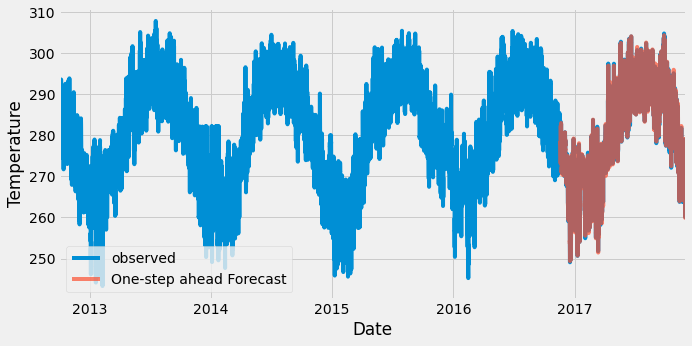

In [158]:
#plot real against predicted values
ax = weather_df['Temperature'].plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

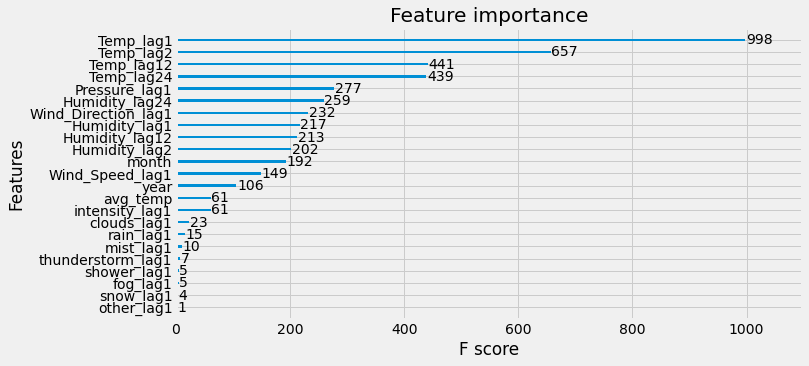

In [159]:
plt.figure(figsize=(10,5))
xgb.plot_importance(xgb_model, ax=plt.gca())

## Drop some features and run again

Seems like nothing much changed, which makes sense since XGB is pretty good at evaluating which predictors are important or not.

In [160]:
ml_df2 = ml_df.copy()
ml_df2.drop(['other_lag1','fog_lag1','shower_lag1','snow_lag1','thunderstorm_lag1','mist_lag1','rain_lag1','clouds_lag1'], axis = 1, inplace = True)

In [161]:
y = ml_df[['Temperature']]
X = ml_df.drop('Temperature', axis =1)

def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(ml_df)*0.80)

X_train, X_test = train_test_split(X, split_len)
y_train, y_test = train_test_split(y, split_len)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_train.columns = X.columns

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
X_test.columns = X.columns

In [207]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [208]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6202727235997456

## Hyperparameter Tuning - HYPEROPT

We perform Bayesian optimization for finding the best hyperparameters using HYPEROPT, which searches through the hyperparameter space of values and finds the best possible values that minimizes the loss function.

In [186]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import metrics

In [187]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [188]:
def tune_model(space): 
    xgb_model = xgb.XGBRegressor(n_estimators =space['n_estimators'], 
                                 max_depth = int(space['max_depth']), 
                                 gamma = space['gamma'],
                                 reg_alpha = int(space['reg_alpha']),
                                 min_child_weight=int(space['min_child_weight']),
                                colsample_bytree=int(space['colsample_bytree']))
        
    xgb_model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric = 'rmse',
            early_stopping_rounds=50,
            verbose=False) 

    pred = xgb_model.predict(X_test)
    #pred = pred.reshape(len(pred),1)
    MSE = metrics.mean_squared_error(y_test, pred)
    print('MSE', MSE)
    return {'loss': MSE, 'status': STATUS_OK}

In [189]:
trials = Trials()

best_hyperparams = fmin(fn = tune_model,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

MSE                                                    
7.424414176735229                                      
MSE                                                                             
7.410996082038712                                                               
MSE                                                                             
7.369120516011939                                                               
MSE                                                                             
7.374571585210336                                                               
MSE                                                                             
7.39897036429697                                                                
MSE                                                                             
7.4074419100878695                                                              
MSE                                                                           

In [190]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7650071206748864, 'gamma': 7.626593207665473, 'max_depth': 7.0, 'min_child_weight': 3.0, 'reg_alpha': 67.0, 'reg_lambda': 0.6339479375279921}


In [194]:
best_hyperparams

{'colsample_bytree': 0.7650071206748864,
 'gamma': 7.626593207665473,
 'max_depth': 7.0,
 'min_child_weight': 3.0,
 'reg_alpha': 67.0,
 'reg_lambda': 0.6339479375279921}

In [209]:
xgb_model = xgb.XGBRegressor(n_estimators=1000,
                             colsample_bytree = 0.765,
                             gamma = 7.62659,
                             max_depth = 7,
                             min_child_weight = 3.0,
                             reg_alpha = 67.0,
                             reg_lambda = 0.6339)

xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [210]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6252758632320766

## Hyperparameter Tuning on Base Model

In [223]:
X_train = X_train[['month','year','Temp_lag1','Temp_lag2','Temp_lag12','Temp_lag24']]
X_test = X_test[['month','year','Temp_lag1','Temp_lag2','Temp_lag12','Temp_lag24']]

In [224]:
trials = Trials()

best_hyperparams = fmin(fn = tune_model,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

MSE                                                    
2.179811424002658                                      
MSE                                                                             
2.067141674486046                                                               
MSE                                                                             
2.147133993353651                                                               
MSE                                                                             
2.1917996737232306                                                              
MSE                                                                             
2.0969103254271904                                                              
MSE                                                                             
2.1146963147507116                                                              
MSE                                                                           

In [225]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8817698784787885, 'gamma': 5.846920982388518, 'max_depth': 4.0, 'min_child_weight': 1.0, 'reg_alpha': 40.0, 'reg_lambda': 0.6361100339020545}


In [226]:
xgb_model = xgb.XGBRegressor(n_estimators=1000,
                             colsample_bytree = 0.88,
                             gamma = 5.85,
                             max_depth = 4,
                             min_child_weight = 1.0,
                             reg_alpha = 40.0,
                             reg_lambda = 0.64)

xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [227]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6194637762228973